## **Лабораторная работа №2**

Загружаем библиотеки и данные CIFAR10 Dataset

# Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»

## Цели работы

**Цель** —разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) с использованием  PyTorch.

## Требования к результатам выполнения работы

1. Требования к структуре и содержимому Jupyter Notebook:
    - Загрузить и проверить данные (необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей).
    - Реализовать архитектуру нейронной сеть с использованием фреймворка PyTorch.
    - Настроить гиперпараметры обучения (например, архитектуры, скорости обучения и размера пачки (batch size)).
    - Вывести ошибку классификации и точность на тренировочном наборе данных по окончании каждой эпохи.
    - Вывести ошибку классификации на тестовом наборе данных и построить график ошибки обучения после обучения.

2. Выбор архитектуры:
    - Необходимо использовать ***сверточные*** архитектуры нейронных сетей
    - Разрешается использовать как готовые архитектуры (например, VGG, ResNet и тд), так и архитектуры разработанные студентом самостоятельно.
    - Реализация должна быть выполнена с нуля в PyTorch, без использования готовых модулей (например, import Resnet недопустимо).
    

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
epochs = 20
learning_rate = 0.01
batch_size = 256

In [9]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform = transform_train)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform_test)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f'Размер обучающего набора: {trainloader.dataset.data.shape}')
print(f'Размер тестового набора: {testloader.dataset.data.shape}')

Files already downloaded and verified
Files already downloaded and verified
Размер обучающего набора: (50000, 32, 32, 3)
Размер тестового набора: (10000, 32, 32, 3)


Тренировочная выборка: 


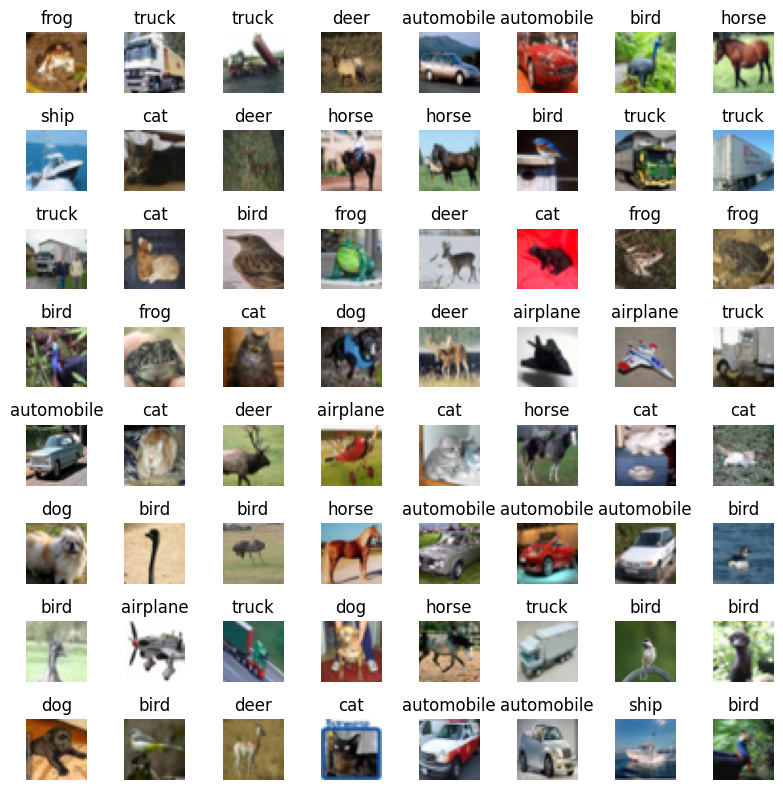

Тестовая выборка: 


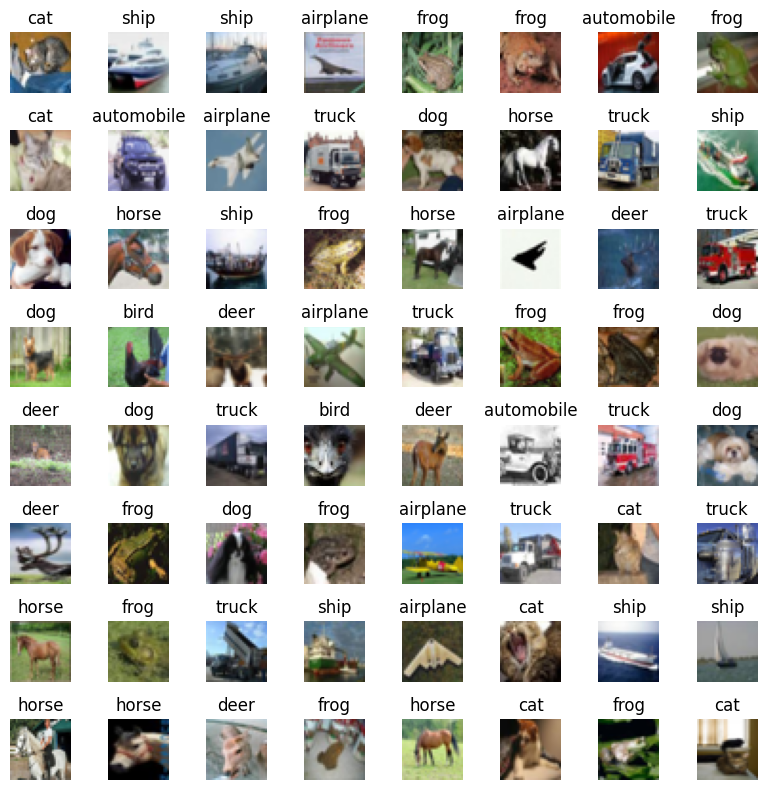

In [10]:
def show_images(X):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            index = i * 8 + j
            axes[i, j].imshow(X.dataset.data[index], cmap=plt.cm.binary)
            axes[i, j].axis('off')
            axes[i, j].set_title(X.dataset.classes[X.dataset.targets[index]])
    plt.tight_layout()
    plt.show()

print('Тренировочная выборка: ')
show_images(trainloader)

print('Тестовая выборка: ')
show_images(testloader)

Реализация нейросети ResNet18

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, 2, stride=1)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock)

Обучение

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('GPU or CPU:', device)

model = ResNet18().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

graphic_loss = []
graphic_acc = []

for epoch in range(epochs):
    loss_list = []
    accuracy_list = []
    model.train()
    time_begin = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        accuracy_list.append(torch.mean(torch.argmax(outputs, dim = 1) == targets, dtype = float))
    time_end = time.time()
    deltaTime = time_end - time_begin
    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Loss: {loss.item():.3f}, "
          f"Accuracy: {torch.stack(accuracy_list).mean():.4f}, "
          f"Time: {deltaTime:.2f} "
          )
    graphic_loss.append(torch.stack(loss_list).mean().cpu().detach().numpy())
    graphic_acc.append(torch.stack(accuracy_list).mean().cpu().detach().numpy())

GPU or CPU: cuda
Epoch 1/20, Loss: 1.494, Accuracy: 0.2985, Time: 42.57 
Epoch 2/20, Loss: 1.304, Accuracy: 0.4579, Time: 42.54 
Epoch 3/20, Loss: 0.970, Accuracy: 0.5825, Time: 42.03 
Epoch 4/20, Loss: 1.140, Accuracy: 0.6621, Time: 43.53 
Epoch 5/20, Loss: 0.646, Accuracy: 0.7111, Time: 42.89 
Epoch 6/20, Loss: 0.515, Accuracy: 0.7602, Time: 42.35 
Epoch 7/20, Loss: 0.523, Accuracy: 0.7924, Time: 42.33 
Epoch 8/20, Loss: 0.490, Accuracy: 0.8175, Time: 42.29 
Epoch 9/20, Loss: 0.632, Accuracy: 0.8354, Time: 42.38 
Epoch 10/20, Loss: 0.522, Accuracy: 0.8505, Time: 42.21 
Epoch 11/20, Loss: 0.479, Accuracy: 0.8658, Time: 42.20 
Epoch 12/20, Loss: 0.299, Accuracy: 0.8758, Time: 42.17 
Epoch 13/20, Loss: 0.415, Accuracy: 0.8851, Time: 42.19 
Epoch 14/20, Loss: 0.262, Accuracy: 0.8946, Time: 42.17 
Epoch 15/20, Loss: 0.328, Accuracy: 0.9011, Time: 42.17 
Epoch 16/20, Loss: 0.146, Accuracy: 0.9077, Time: 42.17 
Epoch 17/20, Loss: 0.157, Accuracy: 0.9176, Time: 42.16 
Epoch 18/20, Loss: 0.28

Тестирование


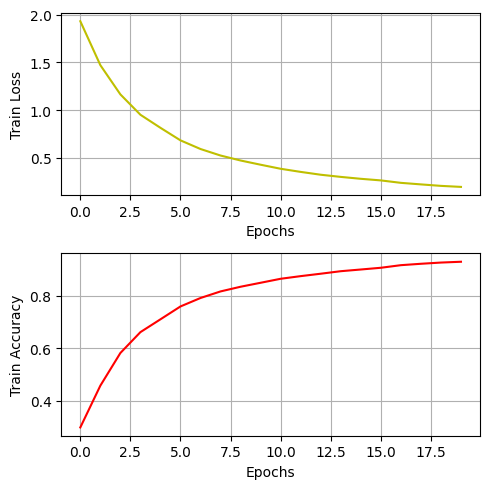

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))

ax1.plot(graphic_loss, color = 'y')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss')
ax1.grid(True)

ax2.plot(graphic_acc, color = 'r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Train Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [15]:
def test():
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            test_acc += (predicted == targets).sum()
    print(f'Test Loss: {loss / total:.5f}')
    print(f'Test Accuracy (%): {100.*correct / total:.2f}%')
    print(f'Test Accuracy: {test_acc / total:.5f}')

test()

Test Loss: 0.00003
Test Accuracy (%): 88.28%
Test Accuracy: 0.88280
